In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last date: {last_date[0]}")

year_from_last_date= (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Year from last date: {year_from_last_date}")

Last date: 2017-08-23
Year from last date: 2016-08-23


C:\Users\choli\anaconda3.1\envs\class_31\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


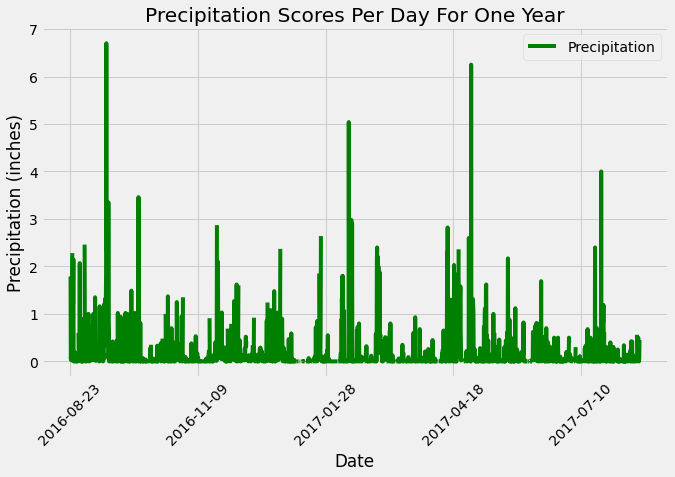

In [11]:
# Perform a query to retrieve the data and precipitation scores
columns = (Measurement.date, Measurement.prcp)
last_year_data = session.query(*columns).filter(Measurement.date >= year_from_last_date).all()
last_year_data

# Save the query results as a Pandas DataFrame and 
last_year_df = pd.DataFrame(last_year_data, columns=['Date','Precipitation'])

#Set the index to the date column
last_year_df.set_index('Date',inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax= last_year_df.plot(color="green", figsize=(10,6), rot=45)
ax.set_title("Precipitation Scores Per Day For One Year")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (inches)")
plt.savefig("Precipitation Plot")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).group_by(Station.station).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_per_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
count_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()
most_active= most_active_station[0]
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.tobs).filter(Measurement.station==most_active).\
    filter(Measurement.date>=year_from_last_date).all()

temp_df = pd.DataFrame(temp_data, columns=["tobs"])
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


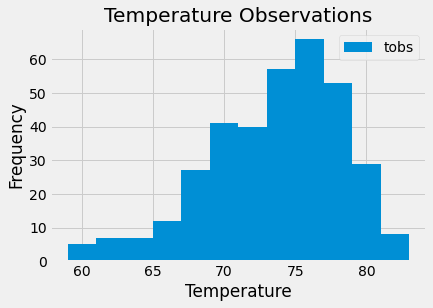

In [17]:
df= pd.DataFrame(temp_df)
df.plot(kind="hist",bins=12);

plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('Temperature Observations')
plt.savefig("Temperature Plot")


# Bonus Challenge Assignment

## Temperature Analysis 1: June Vs December

In [83]:
from scipy.stats import ttest_rel

In [84]:
##TEMPERATURE ANALYSIS 1: JUNE V DECEMBER
query_june="06"

june_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_june).all()
june_avg


[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [85]:
query_dec="12"
dec_avg=session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date)== query_dec ).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [86]:
ttest_rel(june_avg, dec_avg)

Ttest_relResult(statistic=array([6.95696617]), pvalue=array([0.00011759]))

The p-value is less then 0.05 and is therefore statistically significant.
There are many variables for the data which include the station location and the date of the data therefore I would use unpaired t-tests for this data.

## TEMPERATURE ANALYSIS 2: TRIP AVE TEMP

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
   
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
       
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
temps=(calc_temps('2012-02-28', '2012-03-04'))
temps

[(65.0, 70.33333333333333, 74.0)]

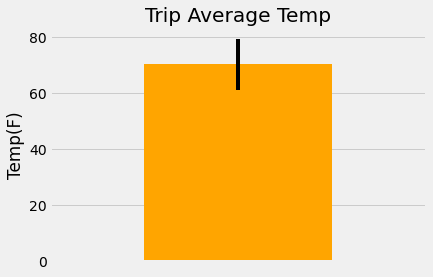

<Figure size 432x288 with 0 Axes>

In [71]:
df = pd.DataFrame(temps, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="orange")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()

# Save the plot
plt.tight_layout()
plt.show()


# Daily Normals

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2012-02-28'
end_date = '2012-03-03'
#merge two tables together
measurement_file = "hawaii_measurements.csv"
station_file = "hawaii_stations.csv"
measurement_data = pd.read_csv(measurement_file)
station_data = pd.read_csv(station_file)
measurement_data = measurement_data.loc[measurement_data["date"] >= '2012-02-28']
measurement_data = measurement_data.loc[measurement_data["date"] <= '2012-03-05']
# total_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.long)
measurement_data.drop("tobs", inplace=True, axis=1)
measurement_data = measurement_data.groupby(["station"]).sum()
measurement_data = measurement_data.sort_values("prcp", ascending = False)
measurement_data
compiled_data = pd.merge(measurement_data, station_data, how = "inner", on = "station")
compiled_data

,station,prcp,name,latitude,longitude,elevation
0,USC00519281,11.08,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00516128,10.32,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00513117,5.79,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00518838,3.84,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
4,USC00519523,2.92,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,1.18,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00511918,0.76,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00514830,0.03,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
8,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2018-01-01'
enddate = '2018-01-07'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [76]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
thistory = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
thistory['Date'] = tripdates
thistory = thistory.set_index("Date")
thistory

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


C:\Users\choli\anaconda3.1\envs\class_31\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, '2018-01-07'),
  Text(0.0, 0, '2018-01-01'),
  Text(1.0, 0, '2018-01-02'),
  Text(2.0, 0, '2018-01-03'),
  Text(3.0, 0, '2018-01-04'),
  Text(4.0, 0, '2018-01-05'),
  Text(5.0, 0, '2018-01-06'),
  Text(6.0, 0, '2018-01-07'),
  Text(7.0, 0, '')])

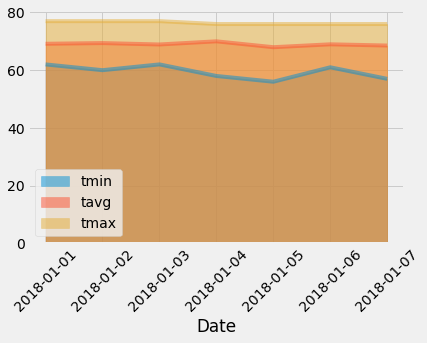

In [77]:
thistory.plot.area(stacked=False)
plt.xticks(rotation=45)